In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [10]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [160]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f"".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [162]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [510]:
# build the dataset


def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [163]:
C = torch.randn((27, 2))

In [164]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [165]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [166]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
h

tensor([[ 0.1446,  0.3797, -0.3397,  ...,  0.5512,  0.9081, -0.9959],
        [-0.3116,  0.3646, -0.9671,  ...,  0.9381,  0.9900, -1.0000],
        [ 0.6405,  0.6447,  0.9944,  ..., -0.8507, -0.7032, -0.9941],
        ...,
        [-0.6645, -0.6148, -0.9993,  ...,  0.8175, -0.3776, -0.7613],
        [ 0.5272,  0.3651,  0.9001,  ..., -0.4303, -0.9572,  0.8236],
        [ 0.0774, -0.5793,  0.6598,  ..., -0.9891, -0.9991,  0.9850]])

In [167]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [168]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [171]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(19.7780)

In [31]:
# ---------------------------- Now made more respectable ----------------------------

In [666]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [667]:
sum(p.nelement() for p in parameters)  # number of parameters in total

10281

In [668]:
for p in parameters:
    p.requires_grad = True

In [669]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [696]:
from tqdm.notebook import tqdm

lri = []
lossi = []
stepi = []
for i in tqdm(range(30000)):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (64,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (32, 3, 2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    # counts = logits.exp()  # (32, 27)
    # probs = counts / counts.sum(1, keepdim=True)  # (32, 27)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

  0%|          | 0/30000 [00:00<?, ?it/s]

2.344273567199707


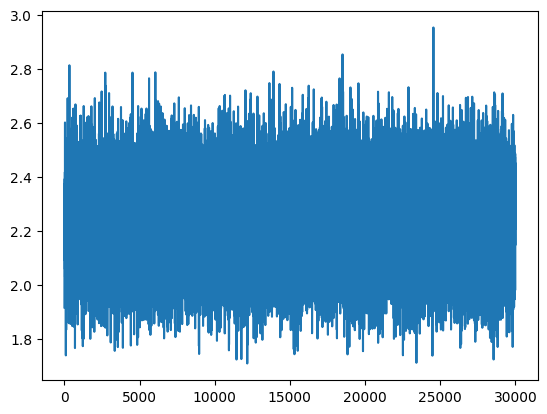

In [702]:
plt.plot(stepi, lossi)

In [703]:
# plt.plot(lri, lossi)

In [704]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2145, grad_fn=<NllLossBackward0>)

In [705]:
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2323, grad_fn=<NllLossBackward0>)

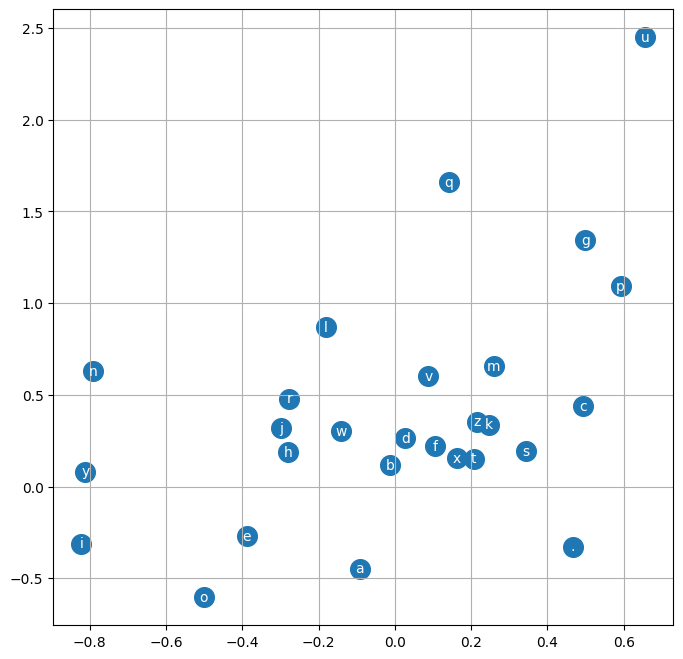

In [707]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")